In [23]:
# Installing H2O; uncomment of H2O is not installed
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# Installing H2O dependencies
# !pip install requests
# !pip install tabulate
# !pip install "colorama>=0.3.8"
# !pip install future

#uncomment of xgboost not installed
# !pip install xgboost

#uncomment if pydotplus not installed; dependency for graphviz
# !pip install pydotplus
# !pip install pydot

# weights and biases for experiment tracking
# !pip install wandb

# category-encoder
# !pip install category_encoders

# uncomment if never before installed and need to convert to onnx
# !pip install onnx
# !pip install skl2onnx
# !pip install onnxruntime
# !pip install onnxmltools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, SCORERS
from sklearn import ensemble

from category_encoders import OneHotEncoder, TargetEncoder, WOEEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from six import StringIO
from IPython.display import Image

import pydotplus
import graphviz

import wandb
import os

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading Data

In [8]:
## INFO: the notebooks in this repo are designed to be run on local system after cloning this repo;
## if running on COLAB, please ensure to download the respective dataset from "../data/interim" folder and use appropriately

train = pd.read_pickle('../data/interim/train.pkl')
test = pd.read_pickle('../data/interim/test.pkl')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77692 entries, 98180 to 14770
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction                       77692 non-null  object 
 1   Gender                             77692 non-null  object 
 2   Customer Type                      77692 non-null  object 
 3   Age                                77692 non-null  int64  
 4   Type of Travel                     77692 non-null  object 
 5   Class                              77692 non-null  object 
 6   Flight Distance                    77692 non-null  int64  
 7   Seat comfort                       77692 non-null  int64  
 8   Departure_Arrival time convenient  77692 non-null  int64  
 9   Food and drink                     77692 non-null  int64  
 10  Gate location                      77692 non-null  int64  
 11  Inflight wifi service              77692 non-null 

In [10]:
train.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure_Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,Onboard service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
98180,satisfied,Male,Loyal Customer,37,Business travel,Business,3785,4,4,4,...,4,4,4,4,4,5,4,4,1,9.0
24974,dissatisfied,Male,Loyal Customer,60,Personal Travel,Eco,1784,3,4,3,...,2,5,3,2,4,4,4,5,0,0.0
69242,dissatisfied,Male,Loyal Customer,27,Business travel,Business,1825,2,3,4,...,2,2,1,3,3,1,2,2,76,57.0
90488,satisfied,Male,Loyal Customer,50,Business travel,Eco,2024,4,4,2,...,4,4,2,5,4,2,4,4,125,129.0
36205,dissatisfied,Male,Loyal Customer,70,Personal Travel,Eco,1435,4,4,4,...,5,5,5,4,5,4,4,5,0,0.0


In [11]:
# data.dropna(axis=1, inplace=True)

In [30]:
X_train = train.iloc[:, 1:].copy()
y_train = train.iloc[:, 0].copy()

X_test = test.iloc[:, 1:].copy()
y_test = test.iloc[:, 0].copy()

X_train.drop('Customer Type', axis=1, inplace=True)
X_test.drop('Customer Type', axis=1, inplace=True)

# X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size=0.2, random_state=16)

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77692 entries, 98180 to 14770
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             77692 non-null  object 
 1   Age                                77692 non-null  int64  
 2   Type of Travel                     77692 non-null  object 
 3   Class                              77692 non-null  object 
 4   Flight Distance                    77692 non-null  int64  
 5   Seat comfort                       77692 non-null  int64  
 6   Departure_Arrival time convenient  77692 non-null  int64  
 7   Food and drink                     77692 non-null  int64  
 8   Gate location                      77692 non-null  int64  
 9   Inflight wifi service              77692 non-null  int64  
 10  Inflight entertainment             77692 non-null  int64  
 11  Online support                     77692 non-null 

In [32]:
y_train

98180        satisfied
24974     dissatisfied
69242     dissatisfied
90488        satisfied
36205     dissatisfied
              ...     
54077     dissatisfied
113068       satisfied
1425      dissatisfied
77485        satisfied
14770     dissatisfied
Name: satisfaction, Length: 77692, dtype: object

# Checking for class-imbalance

satisfied       42452
dissatisfied    35240
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


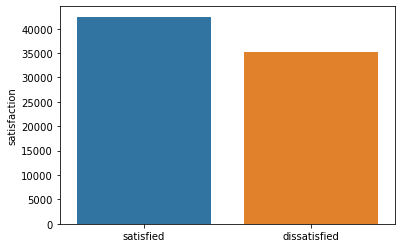

In [33]:
# train data check
x = y_train.value_counts()
print(x)
sns.barplot(x.index, x)

satisfied       14184
dissatisfied    11713
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


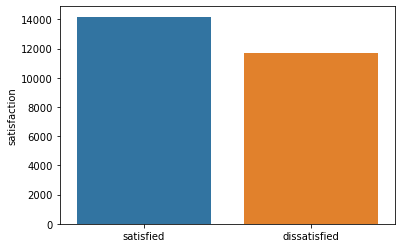

In [34]:
# test data check
x = y_test.value_counts()
print(x)
sns.barplot(x.index, x)

# Identifying Categorical & Numerical features

In [35]:
numerical_features = [x for x in X_train.select_dtypes(exclude = object)]
categorical_features = [x for x in X_train.select_dtypes(include = object)]

In [36]:
print("The numerical features of the dataset are:")
for _ in numerical_features: print(_)

The numerical features of the dataset are:
Age
Flight Distance
Seat comfort
Departure_Arrival time convenient
Food and drink
Gate location
Inflight wifi service
Inflight entertainment
Online support
Ease of Online booking
Onboard service
Leg room service
Baggage handling
Checkin service
Cleanliness
Online boarding
Departure Delay in Minutes
Arrival Delay in Minutes


In [37]:
print("The categorical features of the dataset are:")
for _ in categorical_features: print(_)

The categorical features of the dataset are:
Gender
Type of Travel
Class


In [38]:
for f in categorical_features:
    print("\nThe unique labels in {} is {}".format(f, X_train[f].unique()))
    print("The values in {} is \n{}\n".format(f,  X_train[f].value_counts()))


The unique labels in Gender is ['Male' 'Female']
The values in Gender is 
Female    39404
Male      38288
Name: Gender, dtype: int64


The unique labels in Type of Travel is ['Business travel' 'Personal Travel']
The values in Type of Travel is 
Business travel    53671
Personal Travel    24021
Name: Type of Travel, dtype: int64


The unique labels in Class is ['Business' 'Eco' 'Eco Plus']
The values in Class is 
Business    37174
Eco         34916
Eco Plus     5602
Name: Class, dtype: int64



In [39]:
## mlops-project-new
os.environ["WANDB_API_KEY"] = "0f579240b99e6ed291924359c5de323258326760"

In [40]:
def measure_performance (clasf_matrix):
    measure = pd.DataFrame({
                        'sensitivity': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[0,1]),2)], 
                        'specificity': [round(clasf_matrix[1,1]/(clasf_matrix[1,0]+clasf_matrix[1,1]),2)],
                        'precision': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[1,0]),2)],
                        'overall_acc': [round((clasf_matrix[0,0]+clasf_matrix[1,1])/
                                              (clasf_matrix[0,0]+clasf_matrix[0,1]+clasf_matrix[1,0]+clasf_matrix[1,1]),2)]
                       })
    return measure

In [48]:
def run_model_experiment(data,
                        model, 
                        name, 
                        preprocessor,
                        encoder, 
                        config = None, 
                        tags = None,
                        sweep_config = None):
    
    # splitting the data here is only for testing on wandb
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:].copy(), data.iloc[:, 0].copy(), test_size=0.2, random_state=16)

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    (name, model)])
    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    y_probas = model_pipeline.predict_proba(X_test)
    # labels = ["satisfied", "dissatisfied"]

    # if sweep_config != None:
    #     sweep_id = wandb.sweep(sweep_config)
    # wandb
    wandb.init(project='mlops-project-new', config=None, tags = None)
    wandb.run.name = name

    overall_metrics = measure_performance(metrics.confusion_matrix(y_test, y_pred))

    wandb.log({"accuracy" : overall_metrics.overall_acc[0], 
                "precision": overall_metrics.precision[0],
                "sensitivity": overall_metrics.sensitivity[0], 
                "specificity": overall_metrics.specificity[0]})

    LABELS = np.unique(y_train)
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    wandb.sklearn.plot_classifier(model, 
                                X_train, 
                                X_test, 
                                y_train, 
                                y_test,
                                y_pred, 
                                y_probas,
                                LABELS,
                                model_name=name)

    wandb.Artifact(name, 
                    type = 'model',
                    description = None)

    wandb.save()
    wandb.finish()

    return model_pipeline

In [50]:
encoder1 = OneHotEncoder(cols=categorical_features)
encoder2 = TargetEncoder(cols=categorical_features)
encoder3 = WOEEncoder(cols=categorical_features)
encoders = {"ohe": encoder1, 
            "target": encoder2, 
            "woe": encoder3}

numeric_transformer = StandardScaler()

# OHE models

In [51]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder1, categorical_features)
        ])

## Decision Tree with OHE

In [52]:
dt_ohe_model = tree.DecisionTreeClassifier(max_depth=10)

dt_ohe_model = run_model_experiment(train, dt_ohe_model, "DecisionTreeWithOHE", preprocessor, encoder=encoder1, tags=["DecisionTree", "OHE"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rahav-manoharan (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.91
sensitivity,0.94
specificity,0.92


## RandomForest with OHE

In [53]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_ohe_model = ensemble.RandomForestClassifier(**params)

rf_ohe_model = run_model_experiment(train, rf_ohe_model, "RandomForestOHE", preprocessor, encoder=encoder1, config = params, tags=["RandomForest", "OHE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.91
precision,0.9
sensitivity,0.89
specificity,0.92


## Logistic Regression with OHE

In [54]:
lr_ohe_model = LogisticRegression(max_iter=10000)

lr_ohe_model = run_model_experiment(train, lr_ohe_model, "LogisticRegressionOHE", preprocessor, encoder=encoder1, config = params, tags=["LoristicRegression", "OHE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionOHE.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to 

accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.82
precision,0.8
sensitivity,0.79
specificity,0.84


## XGBoost with OHE

In [55]:
xgb_ohe_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_ohe_model = run_model_experiment(train, xgb_ohe_model, "XGBoostOHE", preprocessor, encoder=encoder1, config = params, tags=["XGBoost", "OHE"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.95
precision,0.94
sensitivity,0.96
specificity,0.95


# Target Encoding

In [56]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder2, categorical_features)
        ])

## Decision Tree with Target Encoding

In [66]:
for i in range(len(train)):
    train['satisfaction'].iloc[i] = 1 if train['satisfaction'].iloc[i]=='satisfied' else 0

train.satisfaction = train.satisfaction.astype('int')

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [67]:
train

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure_Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,Onboard service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
98180,1,Male,Loyal Customer,37,Business travel,Business,3785,4,4,4,...,4,4,4,4,4,5,4,4,1,9.0
24974,0,Male,Loyal Customer,60,Personal Travel,Eco,1784,3,4,3,...,2,5,3,2,4,4,4,5,0,0.0
69242,0,Male,Loyal Customer,27,Business travel,Business,1825,2,3,4,...,2,2,1,3,3,1,2,2,76,57.0
90488,1,Male,Loyal Customer,50,Business travel,Eco,2024,4,4,2,...,4,4,2,5,4,2,4,4,125,129.0
36205,0,Male,Loyal Customer,70,Personal Travel,Eco,1435,4,4,4,...,5,5,5,4,5,4,4,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54077,0,Female,disloyal Customer,28,Business travel,Business,1589,3,3,3,...,1,1,3,4,4,4,4,1,0,0.0
113068,1,Female,Loyal Customer,33,Business travel,Business,224,5,5,5,...,5,5,5,5,4,5,5,3,0,0.0
1425,0,Male,Loyal Customer,62,Personal Travel,Eco Plus,3375,1,1,1,...,1,1,4,1,4,1,4,1,12,0.0
77485,1,Male,Loyal Customer,39,Business travel,Business,1421,4,4,4,...,4,2,2,2,2,3,2,4,0,0.0


In [68]:
dt_target_model = tree.DecisionTreeClassifier(max_depth=10)

dt_target_model = run_model_experiment(train, dt_target_model, "DecisionTreeWithTarget", preprocessor, encoder=encoder2, tags=["DecisionTree", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.9
sensitivity,0.94
specificity,0.92


## RandomForest with Target

In [69]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_target_model = ensemble.RandomForestClassifier(**params)

rf_target_model = run_model_experiment(train, rf_target_model, "RandomForestTarget", preprocessor, encoder=encoder2, config = params, tags=["RandomForest", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.9
precision,0.9
sensitivity,0.89
specificity,0.92


## Logistic Regression with Target Encoding

In [70]:
lr_target_model = LogisticRegression(max_iter=10000)

lr_target_model = run_model_experiment(train, lr_target_model, "LogisticRegressionTarget", preprocessor, encoder=encoder2, config = params, tags=["LoristicRegression", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionTarget.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes 

accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.82
precision,0.8
sensitivity,0.79
specificity,0.84


## XGBoost with Target Encoding

In [71]:
xgb_target_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_target_model = run_model_experiment(train, xgb_target_model, "XGBoostTarget", preprocessor, encoder=encoder2, config = params, tags=["XGBoost", "Target"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.96
precision,0.94
sensitivity,0.96
specificity,0.95


# Weight of Evidence Encoding

In [72]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder3, categorical_features)
        ])

## DecisionTree with WoE Encoding

In [73]:
dt_woe_model = tree.DecisionTreeClassifier(max_depth=10)

dt_woe_model = run_model_experiment(train, dt_woe_model, "DecisionTreeWithWoE", preprocessor, encoder=encoder3, tags=["DecisionTree", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.91
sensitivity,0.94
specificity,0.92


## RandomForest with WoE

In [74]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_woe_model = ensemble.RandomForestClassifier(**params)

rf_woe_model = run_model_experiment(train, rf_woe_model, "RandomForestWoE", preprocessor, encoder=encoder3, config = params, tags=["RandomForest", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.9
precision,0.9
sensitivity,0.89
specificity,0.92


## Logistic Regression with WoE

In [75]:
lr_woe_model = LogisticRegression(max_iter=10000)

lr_woe_model = run_model_experiment(train, lr_woe_model, "LogisticRegressionWoE", preprocessor, encoder=encoder3, config = params, tags=["LoristicRegression", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionWoE.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to 

accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.82
precision,0.8
sensitivity,0.79
specificity,0.84


## XGBoost with WoE

In [76]:
xgb_woe_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_woe_model = run_model_experiment(train, xgb_woe_model, "XGBoostWoE", preprocessor, encoder=encoder3, config = params, tags=["XGBoost", "WoE"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.96
precision,0.94
sensitivity,0.96
specificity,0.95


# One Standard Deviation model selection

In [77]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rahav-manoharan/mlops-project")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # config_list.append(
    #     {k: v for k,v in run.config.items()
    #       if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "name": name_list
    })

In [78]:
runs_df

,summary,name
0,"{'recall': 0.96, '_runtime': 17, 'summary_metr...",XGBoostWoE
1,"{'class_proportions': {'nrows': 4, 'sha256': '...",LogisticRegressionWoE
2,{'feature_importances': {'_type': 'table-file'...,RandomForestWoE
3,"{'precision': 0.91, 'class_proportions': {'sha...",DecisionTreeWithWoE
4,{'class_proportions': {'path': 'media/table/cl...,XGBoostTarget
5,"{'_wandb': {'runtime': 8}, 'accuracy': 0.83, '...",LogisticRegressionTarget
6,"{'_runtime': 22, '_step': 7, '_wandb': {'runti...",RandomForestTarget
7,"{'precision_recall': {'_type': 'table-file', '...",DecisionTreeWithTarget
8,"{'calibration_curve': {'_type': 'table-file', ...",XGBoostOHE
9,"{'_wandb': {'runtime': 10}, 'precision': 0.82,...",LogisticRegressionOHE


In [80]:
runs_results = pd.read_csv('../data/external/run2_wandb_export.csv')
runs_results

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accuracy,precision,sensitivity,specificity
0,XGBoostWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:10:23.000Z,24,NaN,0.96,0.94,0.96,0.95
1,LogisticRegressionWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:09:20.000Z,20,NaN,0.82,0.80,0.79,0.84
2,RandomForestWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:08:50.000Z,26,NaN,0.90,0.90,0.89,0.92
3,DecisionTreeWithWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:08:05.000Z,24,NaN,0.93,0.91,0.94,0.92
4,XGBoostTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:07:24.000Z,23,NaN,0.96,0.94,0.96,0.95
5,LogisticRegressionTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:06:23.000Z,20,NaN,0.82,0.80,0.79,0.84
6,RandomForestTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:05:55.000Z,24,NaN,0.90,0.90,0.89,0.92
7,DecisionTreeWithTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:05:15.000Z,23,NaN,0.93,0.90,0.94,0.92
8,XGBoostOHE,finished,-,rahav-manoharan,NaN,2021-12-07T09:56:52.000Z,23,NaN,0.95,0.94,0.96,0.95
9,LogisticRegressionOHE,finished,-,rahav-manoharan,NaN,2021-12-07T09:55:47.000Z,20,NaN,0.82,0.80,0.79,0.84


In [81]:
# considering precision to be the metric of consideration
sd = np.std(runs_results.precision)
max_val = max(runs_results.precision)
bound = max_val-sd

selected_models = runs_results[runs_results.precision >= bound]
selected_models

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accuracy,precision,sensitivity,specificity
0,XGBoostWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:10:23.000Z,24,NaN,0.96,0.94,0.96,0.95
2,RandomForestWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:08:50.000Z,26,NaN,0.90,0.90,0.89,0.92
3,DecisionTreeWithWoE,finished,-,rahav-manoharan,NaN,2021-12-07T10:08:05.000Z,24,NaN,0.93,0.91,0.94,0.92
4,XGBoostTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:07:24.000Z,23,NaN,0.96,0.94,0.96,0.95
6,RandomForestTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:05:55.000Z,24,NaN,0.90,0.90,0.89,0.92
7,DecisionTreeWithTarget,finished,-,rahav-manoharan,NaN,2021-12-07T10:05:15.000Z,23,NaN,0.93,0.90,0.94,0.92
8,XGBoostOHE,finished,-,rahav-manoharan,NaN,2021-12-07T09:56:52.000Z,23,NaN,0.95,0.94,0.96,0.95
10,RandomForestOHE,finished,-,rahav-manoharan,NaN,2021-12-07T09:55:15.000Z,24,NaN,0.91,0.90,0.89,0.92
11,DecisionTreeWithOHE,finished,-,rahav-manoharan,NaN,2021-12-07T09:53:55.000Z,37,NaN,0.93,0.91,0.94,0.92


### Converting best model to onnx is done in a separate notebook --> 3.0-model_onnx.ipynb

# END OF PART 1 OF NOTEBOOK - RUNNING MODELS WITHOUT "Customer Type" FEATURE

In [83]:
train.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure_Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,Onboard service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
98180,1,Male,Loyal Customer,37,Business travel,Business,3785,4,4,4,...,4,4,4,4,4,5,4,4,1,9.0
24974,0,Male,Loyal Customer,60,Personal Travel,Eco,1784,3,4,3,...,2,5,3,2,4,4,4,5,0,0.0
69242,0,Male,Loyal Customer,27,Business travel,Business,1825,2,3,4,...,2,2,1,3,3,1,2,2,76,57.0
90488,1,Male,Loyal Customer,50,Business travel,Eco,2024,4,4,2,...,4,4,2,5,4,2,4,4,125,129.0
36205,0,Male,Loyal Customer,70,Personal Travel,Eco,1435,4,4,4,...,5,5,5,4,5,4,4,5,0,0.0


In [85]:
train_male = train[train.Gender == 'Male']
train_female = train[train.Gender == 'Female']